# Метрики качества кластеризации

Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Нам неизвестны "истинные" метки объектов, поэтому нужны такие метрики качества, которые можно вычислить по неразмеченной выборке.

### Коэффициент Силуэтта

К-т Силуэтта (англ *Silhouette*) - это метрика, которая не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Интуитивное описание метрики:
* точки внутри кластера должны лежать очень близко друг к другу, то есть кластер должен быть *плотным*
* сами кластера должны лежать как можно дальше друг от друга

Метрика силуэта позволяет учитывать оба этих факта в одной формуле.

Чтобы вычислить его для каждого объекта нужно вычислить для каждого объекта выборки две величины, $a$ (среднее расстояние от данного объекта до объектов из того же кластера) и $b$ (среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект)).

Силуэтом объекта назовём нормализованную разность между этими величинами

$$
s = \frac{b-a}{\max(a,b)}
$$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Эта величина меняется в интервале от $-1$ до $1$:

* -1 значит что кластера плохие, размытые
* 0 значит что кластера накладываются друг на друга
* 1 значит что кластера плотные и хорошо отделены друг от друга

Таким образом, чем ближе значение к-та Силуэтта в единице, тем лучше. Все, что больше $0.5$ хорошие значения, всё что меньше - надо улучшать.

Формулу реализовывать не надо, она уже есть в *sklearn*. Для примера загрузим наш датасет с кластеризацией:

In [2]:
import pickle
import numpy as np

# данные получены с помощью функции make_classification
with open('clustering.pkl', 'rb') as f:
    data_clustering = pickle.load(f)

X = np.array(data_clustering['X'])
Y = np.array(data_clustering['Y'])

Обучим простейшую KMeans-кластеризацию

In [11]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4).fit(X)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Визуализируем результаты

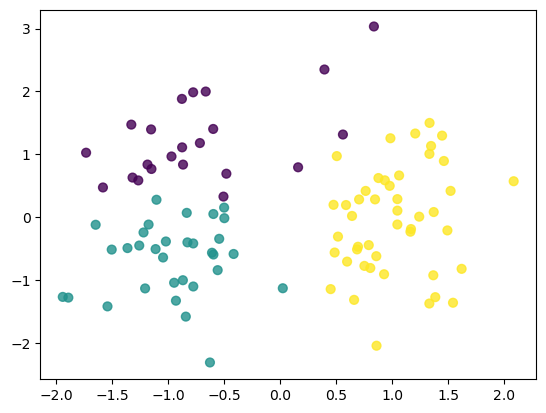

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X[:, 0], X[:, 1], s=40, c=model.labels_, marker='o', alpha=0.8)
plt.show()

Вычислим метрику силуэтта

In [13]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, model.labels_)

print("Качество кластеризации по метрике силуэтта %.3f" % score)

Качество кластеризации по метрике силуэтта 0.452


Таким образом мы вычислили качество нашей кластеризации - например, мы можем выбрать с помощью этой метрики количество кластеров. Как узнать, сколько кластеров лучше - два или три? Давайте посчитаем  метрику силуэта для случая трех кластеров

In [15]:
model = KMeans(n_clusters=3).fit(X)

score = silhouette_score(X, model.labels_)

print("Качество кластеризации по метрике силуэтта  для трёх кластеров %.3f" % score)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Качество кластеризации по метрике силуэтта  для трёх кластеров 0.452


Визуализируем результаты

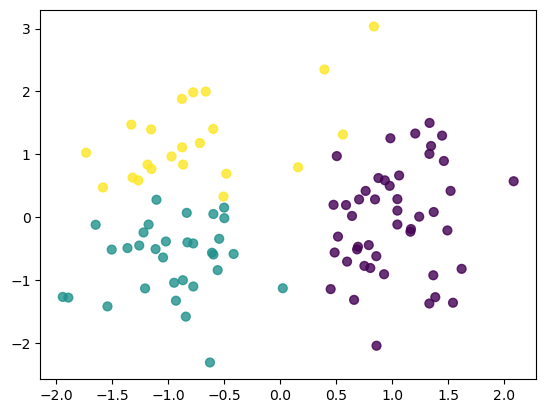

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X[:, 0], X[:, 1], s=40, c=model.labels_, marker='o', alpha=0.8)
plt.show()

Целевая метрика увеличилась - значит, три кластера лучше чем два! Визуально кажется, что два кластера лучше, но метрика показывает обратное - так получилось из-за того, что в кластерах множество выбросов и простой алгоритм K-Means не может выделить правильные кластеры. Косвенно это значит, что алгоритм не подходит для решения нашей задачи. В реальных задачах нужно доверять метрике, а не собственным глазам.

### Adjusted Mutual Information

Мы знаем, что в задаче кластеризации можно использовать метрику "коэффициент Силуэтта". Это очень удобно и идеально подходит для случаев, когда выборку невозможно разметить - например, из-за большого объёма.

Иногда в задаче кластеризации мы всё-таки знаем "правильные" метки кластеров - например, для разметки можно привлечь помощников. Если "истинная" метка кластера нам известна, то можно применять такую метрику как Скорректированная взаимная информация (Adjusted Mutual Information).

По сути эта метрика сравнивает два вероятностных распределения меток кластеров - истинное распределение и то, которое получили в результате кластеризации, про эту метрику есть подробная статья на [википедии](https://en.wikipedia.org/wiki/Adjusted_mutual_information), с понятием кластеризации мы уже встречались в модуле 5, когда говорили про деревья решений.

AMI принимает значение $1$ в случае, если кластеры идентичны, у нас идеальное разбиение. В случае, если кластеризация совершенно не удалась, метрика примет значение $0$. На практике хорошими считаются все значения выше $0.7$

При решении рабочих задач формулу реализовывать не нужно, существует готовое библиотечное решение в *sklearn*

In [17]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

model = KMeans(n_clusters=3).fit(X)
score = adjusted_mutual_info_score(Y, model.labels_, average_method='arithmetic')

print("Качество кластеризации по метрике AMI %.3f" % score)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Качество кластеризации по метрике AMI 0.614
